<a href="https://colab.research.google.com/github/crisbpadilla/CapstoneProject-1-M2M/blob/main/CapstoneProject_2_FinalRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
if 'sklearn_installed' not in globals():
  # Make sure a suitable version of sklearn is installed
  !pip install scikit-learn~=0.23

sklearn_installed = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 37.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# Machine learning- compressive strenght prediction modeling
  In the present capston project, the same data used in the first project will be scaled and transform to preprocess the data, prepared the training and testing data and evaluate the different regression models that could be used to predict the compressive strength of the concrete mix.

  So, the dataset was obtain from kaggle:

In [3]:
import pandas as pd
import numpy as np

concrete=pd.read_csv('concrete.csv')
concrete.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In the first capston project it was possible to identify that the main components that helps to improve the development and higher values of compressive strength were the SCM and the superplastice.
So due this, we will firstly checked the correlation matrix between the variables to have  a better idea of it and see if this could help to take desicions in the future models.

In [4]:
from bokeh.plotting import figure, output_notebook, show, output_notebook
from bokeh.models import ColumnDataSource, LinearColorMapper,ColorBar

output_notebook()
material_corr=concrete.corr()

material_corr = material_corr.stack().reset_index()
material_corr.columns = ['x', 'y', 'value']

material_corr['value'] = material_corr['value'].round(2)

source = ColumnDataSource(material_corr)

# Define color mapper
color_mapper = LinearColorMapper(palette="Inferno256", low=-1, high=1)

# Create figure
p = figure(title="Correlation Heatmap", x_range=list(concrete.columns), y_range=list(concrete.columns),
           x_axis_location="above", width=600, height=600,
           tools="hover", tooltips="@x, @y: @value{0.2f}")

p.rect(x="x", y="y", width=1, height=1, source=source,
       fill_color={'field': 'value', 'transform': color_mapper}, line_color=None)

# Add text annotations
from bokeh.models import LabelSet
labels = LabelSet(x='x', y='y', text='value', source=source,text_align='center',
                  text_baseline='middle',text_font_size='8pt',text_color='white')
p.add_layout(labels)

# Add color bar
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, border_line_color=None, location=(0, 0))
p.add_layout(color_bar, 'right')

p.xaxis.major_label_orientation = 0.75

# Show plot
show(p)


Reviewing the heatmap it is possible to observe the inverse correlation between water an superplastic, they are both lightly correlated ( superplastic is used to speed up the compressive strength gain and the reduction of water in the mix). Anyway, this correlation is to low to apply any dimension reduction mergin this two variables, as the superlpastic increased notably the speed up of the compressive strenght gain in the concrete, make it a relevant variable by itself.


# Preprocessing data

In [5]:
print(concrete.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB
None


the dataframe is build by the raw materials that composed the concrete mix  (kg/m^3), age (days) and compressive strength of the sample.

with the idea of see the impact of adding   categorical values to the model, depending the type of mix, the next code includes the next categories.

    * all mix
    * slag
    * ash
    * superplastic
    * slag-ash
    * slag-superplastic
    * ash-superplastic.
    * just cement


In [6]:
concrete_pluscat=concrete.copy()
# cuales son los escenarios? 9 (matriz 3x3) , la mitad menos 1 ~ 3
#a) slag-ash b)slag-superplastic c)ash-superplastic

concrete_pluscat['type_mix'] = 'all mix'
concrete_pluscat.loc[
    (concrete_pluscat['slag']>0) & (concrete_pluscat[['superplastic','ash']] == 0).all(axis=1),
    'type_mix',
] = 'slag'
concrete_pluscat.loc[
    (concrete_pluscat['ash']>0) & (concrete_pluscat[['superplastic','slag']] == 0).all(axis=1),
    'type_mix',
] = 'ash'
concrete_pluscat.loc[
    (concrete_pluscat['superplastic']>0) & (concrete_pluscat[['slag','ash']] == 0).all(axis=1),
    'type_mix',
] = 'superplastic'

concrete_pluscat.loc[
    (concrete_pluscat[['slag', 'ash']].gt(0).all(axis=1)) & (concrete_pluscat['superplastic'] == 0),
    'type_mix',
] = 'slag-ash'

concrete_pluscat.loc[
    (concrete_pluscat[['slag', 'superplastic']].gt(0).all(axis=1)) & (concrete_pluscat['ash'] == 0),
    'type_mix',
] = 'slag-superplastic'

concrete_pluscat.loc[
    (concrete_pluscat[['ash', 'superplastic']].gt(0).all(axis=1)) & (concrete_pluscat['slag'] == 0),
    'type_mix',
] = 'ash-superplastic'
concrete_pluscat.loc[
    (concrete_pluscat['cement']>0) & (concrete_pluscat[['superplastic','slag','ash']] == 0).all(axis=1),
    'type_mix',
] = 'just cement'

In [7]:
concrete_pluscat.groupby('type_mix')['strength'].count()

,strength
type_mix,
all mix,225
ash,6
ash-superplastic,233
just cement,209
slag,164
slag-superplastic,170
superplastic,23


there is no slag-ash mix. so when the get_dummies method is applyed this will give 6 dummie columns instead of 7, considering that the first one will be drop.

###Preparing data for modelling

  As was seen in the first capstone project, there are samples distributed in all the categories related with the type of mix before the 100 days (seen in the next graph)
  

In [8]:
from bokeh.plotting import figure, show
from bokeh.palettes import Category20
from bokeh.io import output_notebook
import random

output_notebook()


copy_nfile=concrete_pluscat.copy()
type_group=copy_nfile['type_mix'].unique()

if len(type_group)<=2:
  col=[Category20[5][0],Category20[5][3]]
else:
  col=Category20[len(type_group)]


type_mix=sorted(copy_nfile['type_mix'].unique())
gf1=copy_nfile[copy_nfile['type_mix']==type_mix[0]]
gf2=copy_nfile[copy_nfile['type_mix']==type_mix[1]]
gf3=copy_nfile[copy_nfile['type_mix']==type_mix[2]]
gf4=copy_nfile[copy_nfile['type_mix']==type_mix[3]]
gf5=copy_nfile[copy_nfile['type_mix']==type_mix[4]]
gf6=copy_nfile[copy_nfile['type_mix']==type_mix[5]]

z=figure(title='strength vs age by mix_type',height=350)
z.scatter(x=sorted(gf1['age'].unique()),y=gf1.groupby('age')['strength'].mean(),color=col[0],legend_label=type_mix[0])
z.scatter(x=sorted(gf2['age'].unique()),y=gf2.groupby('age')['strength'].mean(),color=col[1],legend_label=type_mix[1])
z.scatter(x=sorted(gf3['age'].unique()),y=gf3.groupby('age')['strength'].mean(),color=col[2],legend_label=type_mix[2])
z.scatter(x=sorted(gf4['age'].unique()),y=gf4.groupby('age')['strength'].mean(),color=col[3],legend_label=type_mix[3])
z.scatter(x=sorted(gf5['age'].unique()),y=gf5.groupby('age')['strength'].mean(),color=col[4],legend_label=type_mix[4])
z.scatter(x=sorted(gf6['age'].unique()),y=gf6.groupby('age')['strength'].mean(),color=col[5],legend_label=type_mix[5])
z.xaxis.axis_label='age (days)'
z.yaxis.axis_label='strength (Mpa)'
z.add_layout(z.legend[0], 'right')
z.background_fill_color = "#eff0e7"
show(z)

The dummies for the categorical values were created so we can added to the model later:

In [9]:
# Create the dataframe with all the numerical and categorical values
concrete_data=pd.get_dummies(data=concrete_pluscat,columns=['type_mix'],drop_first=True).astype(int)
concrete_data.head()
concrete_data.shape


(1030, 15)

In [10]:
RED = "\033[31m"
RESET = "\033[0m"

ptg_data28=(len(concrete[concrete['age']<=100])/len(concrete))*100


print(f'The percentage of data under 100 days over the total is {RED}{round(ptg_data28,3)} %{RESET}')

print(f"{RED}{len(concrete[concrete['age']>100])}{RESET} samples are over 100 days")
print(f"{RED}{len(concrete[concrete['age']<=100])}{RESET} samples are under 100 days")

The percentage of data under 100 days over the total is 93.981 %
62 samples are over 100 days
968 samples are under 100 days


in the first capstone project, it is possible to identify that big amount of the data is below 100 days, using mathematical operations we can observe that ***93,981 %*** of the samples are obtain before the 100 days, so this data is the most representative of the whole dataset, being the samples above that age potential noise in the model as they also represent values of just two particular mixes (slag and all mix). Cause of this, the samples above 100 days will be removed of the model an this will predict compressive strength between 0 and 100 days.

### Creation of the taining and testing samples
 The samples are split in testing and training data for dependent and independent variables using 'train_test_split' method. so we can use this data for further modeling, modeling over two different set of data:

    * Full data
    * Data filtered by age (age under 100 days)


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X=concrete_data.drop(columns=['strength'])
y=concrete_data['strength']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)


In [12]:
# concrete_model_data=concrete_data[concrete_data['age']<=100]

concrete_model_data=concrete_data[concrete_data['age']<=100]
X_100=concrete_model_data.drop(columns=['strength'])
y_100=concrete_model_data['strength']
X_train_100,X_test_100,y_train_100,y_test_100=train_test_split(X_100,y_100,test_size=0.2)

In [13]:
# Seprating my numeric variables and nominal/categorical values
num_col=[a for a in concrete.columns]
num_col.remove('strength')
#numerical values
X_train_num=X_train[num_col]
X_test_num=X_test[num_col]
#nominal values
X_train_nom=X_train.drop(columns=num_col)
X_test_nom=X_test.drop(columns=num_col)

#------------------------------------------------------------------------------

#nominal values dataset 2 (100 days)
X_train_nom_100=X_train_100.drop(columns=num_col)
X_test_nom_100=X_test_100.drop(columns=num_col)
#numerical values dataset 2 (100 days)
X_train_num_100=X_train_100[num_col]
X_test_num_100=X_test_100[num_col]


##Scalling the data

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scale_data=StandardScaler()


X_train_num_scale=scale_data.fit_transform(X_train_num)
X_test_num_scale=scale_data.fit_transform(X_test_num)

#dataset 2 (100 days)
X_train_num_scale_100=scale_data.fit_transform(X_train_num_100)
X_test_num_scale_100=scale_data.fit_transform(X_test_num_100)

print(pd.DataFrame(X_train_num_scale))

            0         1         2         3         4         5         6  \
0    0.071353  1.464484 -0.859258 -1.750398  0.849421  0.381841  0.372812   
1   -0.120067  0.476722 -0.859258  2.172525 -1.001337 -0.538636 -1.280992   
2   -0.263632 -0.832636  0.682169 -1.656995  1.017672  0.407409  1.566535   
3    0.971026 -0.832636 -0.859258  2.172525 -1.001337 -0.538636 -1.280992   
4    0.415908 -0.832636 -0.859258  1.004988 -1.001337 -0.001691  0.335508   
..        ...       ...       ...       ...       ...       ...       ...   
819 -0.254061  0.281467  0.324059  0.584675  0.344669 -1.778722  0.596635   
820 -0.388055  0.982088 -0.859258  0.164362 -1.001337  0.842079 -0.485176   
821 -1.249444  0.763862  0.822298  0.491272  0.008168 -1.050011  0.086816   
822  0.578615 -0.832636 -0.859258  0.724780 -1.001337 -0.078398  0.099251   
823 -0.263632 -0.832636  0.977998  0.304466 -0.160083  0.688666 -0.199180   

            7  
0    0.156441  
1    2.110303  
2   -0.284753  
3    3.5284

# **Testing Models**

###Lineal model

In [15]:
from sklearn import linear_model
#using all data
lineal=linear_model.LinearRegression()
lineal.fit(X_train_num_scale,y_train)
l0=round(lineal.score(X_train_num_scale,y_train),3)
l1=round(lineal.score(X_test_num_scale,y_test),3)
score_lineal=[l0,l1]

#dataset 2 (100 days)
lineal_100=linear_model.LinearRegression()
lineal_100.fit(X_train_num_scale_100,y_train_100)
la=round(lineal_100.score(X_train_num_scale_100,y_train_100),3)
lb=round(lineal_100.score(X_test_num_scale_100,y_test_100),3)
score_lineal_100=[la,lb]
df_lineal=pd.DataFrame({'type_score':['Training','Testing'],'all data R^2':score_lineal,'filtered data R^2':score_lineal_100}).set_index('type_score')
print('values of scores for lineal model')
print(df_lineal)

values of scores for lineal model
            all data R^2  filtered data R^2
type_score                                 
Training           0.622              0.768
Testing            0.578              0.694


###Reciprocal logaritmic


In [16]:
import numpy as np

def addReciprocalLogFeatures(numeric):
    log_feats = numeric.copy()
    valid = (log_feats != 1) & (log_feats > 0)
    log_feats[valid] = np.log(log_feats[valid]) / np.log(10)
    log_feats[log_feats <= 0] = 1e-10
    rec_log_feats = log_feats
    return np.hstack([numeric, rec_log_feats, numeric * rec_log_feats])

X_train_reclog = addReciprocalLogFeatures(X_train_num_scale)
X_test_reclog = addReciprocalLogFeatures(X_test_num_scale)

#dataset 2 (100 days)

X_train_reclog_100 = addReciprocalLogFeatures(X_train_num_scale_100)
X_test_reclog_100 = addReciprocalLogFeatures(X_test_num_scale_100)


In [17]:
#log regression
lineal_rl=linear_model.LinearRegression()
lineal_rl.fit(X_train_reclog,y_train)
lr0=lineal_rl.score(X_train_reclog,y_train)
lr1=lineal_rl.score(X_test_reclog,y_test)
score_lr=[lr0,lr1]
#dataset 2 (100 days)
lineal_rl_100=linear_model.LinearRegression()
lineal_rl_100.fit(X_train_reclog_100,y_train_100)
lr0_100=lineal_rl_100.score(X_train_reclog_100,y_train_100)
lr1_100=lineal_rl_100.score(X_test_reclog_100,y_test_100)
score_lr_100=[lr0_100,lr1_100]
predicted_reclog_100=lineal_rl_100.predict(X_test_reclog_100)

df_lr=pd.DataFrame({'type_score':['Training','Testing'],'all data R^2':score_lr,'filtered data R^2':score_lr_100}).set_index('type_score')
print('values of scores for lineal model')
print(df_lr)

values of scores for lineal model
            all data R^2  filtered data R^2
type_score                                 
Training        0.798477           0.850381
Testing         0.733058           0.760842


In [18]:
BLUE = "\033[1;34m"
RESET = "\033[0m"
print(f"{BLUE}Rec.log model{RESET}")
df1 = pd.DataFrame({"Predicted_100": predicted_reclog_100, "Actual_100": y_test_100})
df1['% Difference(100 days)'] = (abs(df1['Predicted_100']-df1['Actual_100'])/df1['Actual_100'])*100

print("Percentage Difference between Predicted and Actual Values (rec.log model with age bellow 100 days)")
print(df1.head())
print(f"\nMean % Difference between Predicted and Actual Values of data bellow 100 days:{BLUE}{str(round(df1['% Difference(100 days)'].mean(),3))}%{RESET}")

Rec.log model
Percentage Difference between Predicted and Actual Values (rec.log model with age bellow 100 days)
     Predicted_100  Actual_100  % Difference(100 days)
709      45.784361          53               13.614413
215      28.368033          26                9.107820
411      60.493817          58                4.299684
555      34.224802          27               26.758526
544      18.398807          18                2.215595

Mean % Difference between Predicted and Actual Values of data bellow 100 days:23.881%


###cubic model

In [19]:
#lineal regession gives a r2 too low and the function seems to fit to a log function
from sklearn.preprocessing import PolynomialFeatures,FunctionTransformer

from sklearn.pipeline import make_pipeline

square = PolynomialFeatures(degree=3, include_bias=False)
X_train_scale_cubic = square.fit_transform(X_train_num_scale)
X_test_scale_cubic = square.fit_transform(X_test_num_scale)

reg=linear_model.LinearRegression()
reg.fit(X_train_scale_cubic,y_train)
prediction_train=reg.predict(X_train_scale_cubic)
prediction_test=reg.predict(X_test_scale_cubic)

C0=reg.score(X_train_scale_cubic,y_train)
C1=reg.score(X_test_scale_cubic,y_test)
cubic_score=[C0,C1]

#filtered data
cubic_f=PolynomialFeatures(degree=3, include_bias=False)
X_train_scale_cubic_100 = cubic_f.fit_transform(X_train_num_scale_100)
X_test_scale_cubic_100 = cubic_f.fit_transform(X_test_num_scale_100)

C0_100=reg.score(X_train_scale_cubic_100,y_train_100)
C1_100=reg.score(X_test_scale_cubic_100,y_test_100)
cubic_score_100=[C0_100,C1_100]
Predict_cubic=reg.predict(X_test_scale_cubic)

df_cubic=pd.DataFrame({'type_score':['Training','Testing'],'All data R^2':cubic_score,'Filtered data R^2':cubic_score_100}).set_index('type_score')
print('values of scores for cubic model')
print(df_cubic)

values of scores for cubic model
            All data R^2  Filtered data R^2
type_score                                 
Training        0.926593          -0.332878
Testing         0.809566          -0.583963


In [20]:
print(f"{BLUE}Cubic model{RESET}")
df_cubic = pd.DataFrame({"Predicted": Predict_cubic, "Actual": y_test})
df_cubic['% Difference(all data)'] = (abs(df_cubic['Predicted']-df_cubic['Actual'])/df_cubic['Actual'])*100

print("Percentage Difference between Predicted and Actual Values (cubic model)")
print(df_cubic.head())
print(f"\nMean % Difference between Predicted and Actual Values with all data:{BLUE}{str(round(df_cubic['% Difference(all data)'].mean(),3))} %{RESET}")


Cubic model
Percentage Difference between Predicted and Actual Values (cubic model)
     Predicted  Actual  % Difference(all data)
86   70.895905      67                5.814784
860  31.239294      33                5.335472
693  12.139005      16               24.131216
67   42.526780      44                3.348227
573  19.058516      23               17.136887

Mean % Difference between Predicted and Actual Values with all data:17.996 %


**Removing the data above 100 days improve the model consideraby  the scores in all 3 different models but the cubic polynomial one, which shows very negative values.**

## ***Adding nominal values***
  The two best models were selected and added the nominal values, so in this way will be possible to asses their performance.
  
  * Cubic model with all data
  * rec.log model with filtered data

In [21]:

X_train_ln_full = np.hstack([X_train_scale_cubic, X_train_nom])
X_test_ln_full = np.hstack([X_test_scale_cubic, X_test_nom])
#filtered data
X_train_ln_full_100 = np.hstack([X_train_reclog_100, X_train_nom_100])
X_test_ln_full_100 = np.hstack([X_test_reclog_100, X_test_nom_100])
X_train_ln_full.shape

(824, 170)

In [22]:
RED = "\033[1;31m"
GREEN= "\033[1;32m"
RESET = "\033[0m"

ln_model= linear_model.RidgeCV()
ln_model.fit(X_train_ln_full,y_train)
train_predict_ln=ln_model.predict(X_train_ln_full)
test_predict_ln=ln_model.predict(X_test_ln_full)
print('Considering the nominal values for the two best models in their respective scenarios')
print('Cubic model with all the data')
print(f'For the train data,the R^2 for the {RED}cubic model{RESET} is : {round(ln_model.score(X_train_ln_full,y_train),3)}')
print(f'For the test data,the R^2 for the {RED}cubic model{RESET}is : {round(ln_model.score(X_test_ln_full,y_test),3)}')

#filtered model

ln_model_100= linear_model.RidgeCV()
ln_model_100.fit(X_train_ln_full_100,y_train_100)
train_predict_ln_100=ln_model_100.predict(X_train_ln_full_100)
test_predict_ln_100=ln_model_100.predict(X_test_ln_full_100)

print('logaritmic model filtered (bellow 11 days)')
print(f'For the train data,the R^2 for the {GREEN}reciprocal log model{RESET} is : {round(ln_model_100.score(X_train_ln_full_100,y_train_100),3)}')
print(f'For the test data,the R^2 for the {GREEN}reciprocal log model{RESET} is : {round(ln_model_100.score(X_test_ln_full_100,y_test_100),3)}')

Considering the nominal values for the two best models in their respective scenarios
Cubic model with all the data
For the train data,the R^2 for the cubic model is : 0.922
For the test data,the R^2 for the cubic modelis : 0.865
logaritmic model filtered (bellow 11 days)
For the train data,the R^2 for the reciprocal log model is : 0.853
For the test data,the R^2 for the reciprocal log model is : 0.761


In [23]:
df0 = pd.DataFrame({"Predicted": test_predict_ln, "Actual": y_test})
df1 = pd.DataFrame({"Predicted_100": test_predict_ln_100, "Actual_100": y_test_100})
df0['% Difference(all data)'] = (abs(df0['Predicted']-df0['Actual'])/df0['Actual'])*100
df1['% Difference(100 days)'] = (abs(df1['Predicted_100']-df1['Actual_100'])/df1['Actual_100'])*100

print("Percentage Difference between Predicted and Actual Values (cubic model)")
print(df0.head())
print('----------------------------------------------')
print("Percentage Difference between Predicted and Actual Values (rec.log model with age bellow 100 days)")
print(df1.head())
print(f"\nMean % Difference between Predicted and Actual Values with all data:{RED}{str(round(df0['% Difference(all data)'].mean(),3))} %{RESET}")
print(f"\nMean % Difference between Predicted and Actual Values of data bellow 100 days:{GREEN}{str(round(df1['% Difference(100 days)'].mean(),3))}%{RESET}")

Percentage Difference between Predicted and Actual Values (cubic model)
     Predicted  Actual  % Difference(all data)
86   70.090953      67                4.613363
860  34.562523      33                4.734917
693  14.563516      16                8.978023
67   38.093027      44               13.424938
573  23.899794      23                3.912147
----------------------------------------------
Percentage Difference between Predicted and Actual Values (rec.log model with age bellow 100 days)
     Predicted_100  Actual_100  % Difference(100 days)
709      44.428212          53               16.173185
215      28.992548          26               11.509799
411      55.578593          58                4.174840
555      32.853237          27               21.678657
544      16.502690          18                8.318388

Mean % Difference between Predicted and Actual Values with all data:15.247 %

Mean % Difference between Predicted and Actual Values of data bellow 100 days:23.997%


#Neural Network

In [24]:
#using neural network
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor


In [25]:
Xnn=concrete_pluscat.drop(columns='strength')
y=concrete_pluscat['strength']
X_train,X_test,y_train,y_test=train_test_split(Xnn,y,test_size=0.2)

In [26]:
preprocessor = make_column_transformer(
    (OneHotEncoder(), make_column_selector(dtype_include=object)),
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
)
preprocessor

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fe8211a3e10>),
                                ('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fe85af148d0>)])

In [27]:
neural_net = MLPRegressor(hidden_layer_sizes=(25,),#7,0.003 works 18,0.003 better 25.0.003
    max_iter=1000,
    learning_rate_init=0.003,
    )
C_strength_model = make_pipeline(preprocessor, neural_net)
C_strength_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe8211a3e10>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe85af148d0>)])),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=(25,),
                              learning_rate_init=0.003, max_iter=1000))])

In [28]:
# C_strength_model.fit(X_train, y_train)
# C_strength_model[:-1].transform(Xnn).shape[1]

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe8211a3e10>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe85af148d0>)])),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=(25,),
                              learning_rate_init=0.003, max_iter=1000))])

In [39]:
#Hyperparameters search

#first of all we create a list of parameters that we want to evaluate
#this parameter list is a dictionary with the key values representing
#the variable that we want to analyse
#we can check the parameters that we can assess with the method get_params
# applying it over the pipeline
C_strength_model.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'columntransformer', 'mlpregressor', 'columntransformer__force_int_remainder_cols', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__onehotencoder', 'columntransformer__standardscaler', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntransformer__onehotencoder__feature_name_combiner', 'columntransformer__onehotencoder__handle_unknown', 'columntransformer__onehotencoder__max_categories', 'columntransformer__onehotencoder__min_frequency', 'columntransformer__onehotencoder__sparse_output', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__wit

In [64]:
parameters_nn={
    'mlpregressor__hidden_layer_sizes':[(15,),(20,),(25,),(30,)],#[(x, y) for x in range(10, 40) for y in range(0, 10)],(a,) for a in range(15,40)]
    'mlpregressor__max_iter':[1000,1500],
    'mlpregressor__learning_rate_init':[0.003,0.01]
    }

In [65]:
from sklearn.model_selection import GridSearchCV

grid_search= GridSearchCV(C_strength_model,param_grid=parameters_nn,scoring='r2',n_jobs=-1)
grid_search.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fe8211a3e10>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fe85af148d0>)])),
                                       ('mlpregressor',
                                        MLPRegressor(hidden_layer_sizes=(25,),
                                                     learning_rate_init=0.003,
                                                     max_iter=1000))]),
             n_jobs=-1,
             param_grid={'mlpregressor__hidden_layer_sizes': [(15,), (20,),
                                                              (25,), (30,)],
                         'mlpregressor__learning_rate_init': [0.003, 0.01],
                         'mlpregressor__max_iter': [1000, 1500]},
             scoring='r2')

In [74]:
Best_pipeline=grid_search.best_estimator_
grid_search.best_score_

0.8675099425631618

532
-319


<Axes: title={'center': 'Loss Curve'}>

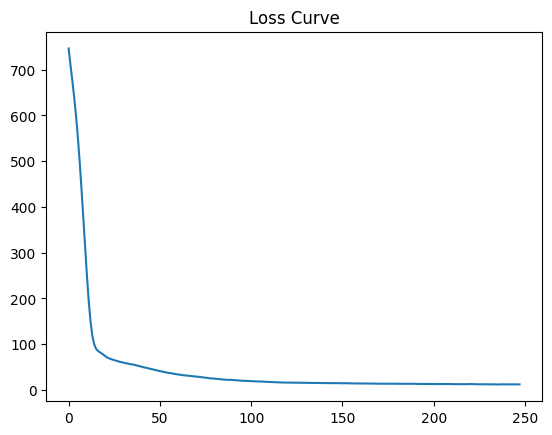

In [69]:
num_iterations = C_strength_model.named_steps.mlpregressor.n_iter_
print(num_iterations)#The length of the number of iterations is
display_iter=int(-(num_iterations*0.60))
print(display_iter)
# equal to the length of the error given by the loss curve
#loss curve
loss_curve=Best_pipeline.named_steps.mlpregressor.loss_curve_
pd.Series(loss_curve[display_iter:]).plot.line(title='Loss Curve')

In [71]:
print(f" The R^2 for the training data is {round(Best_pipeline.score(X_train, y_train),3)}")
print(f"the R^2 for the testing data is {round(Best_pipeline.score(X_test, y_test),3)}")

 The R^2 for the training data is 0.911
the R^2 for the testing data is 0.872


In [73]:
prediction_nn=Best_pipeline.predict(X_test)
dfnn = pd.DataFrame({"Predicted": prediction_nn, "Actual": y_test})
dfnn['% Difference'] = (abs(dfnn['Predicted']-dfnn['Actual'])/dfnn['Actual'])*100
print("Percentage Difference between Predicted and Actual Values (feedforward neural network)")
print(dfnn.head())
print("\nMean % Difference between Predicted and Actual Values: " + str(round(dfnn['% Difference'].mean(),3)) +"%")

Percentage Difference between Predicted and Actual Values (feedforward neural network)
     Predicted  Actual  % Difference
135  60.106706      56      7.333403
235   4.111282       6     31.478638
471  23.865205      26      8.210750
123  39.963413      45     11.192415
361  35.598846      33      7.875292

Mean % Difference between Predicted and Actual Values: 15.391%


In [33]:
results=[]
results2=[]
n_runs=10
for i in range(n_runs):
  #Split all data set

  X=concrete_data.drop(columns=['strength'])
  y=concrete_data['strength']
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

  # split the filtered data
  concrete_model_data=concrete_data[concrete_data['age']<=100]
  X_100=concrete_model_data.drop(columns=['strength'])
  y_100=concrete_model_data['strength']
  X_train_100,X_test_100,y_train_100,y_test_100=train_test_split(X_100,y_100,test_size=0.2)


  # Seprating my numeric variables and nominal/categorical values
  num_col=[a for a in concrete.columns]
  num_col.remove('strength')
  #numerical values
  X_train_num=X_train[num_col]
  X_test_num=X_test[num_col]
  #nominal values
  X_train_nom=X_train.drop(columns=num_col)
  X_test_nom=X_test.drop(columns=num_col)

  #numerical values dataset 2 (100 days)
  X_train_num_100=X_train_100[num_col]
  X_test_num_100=X_test_100[num_col]
  #nominal values dataset 2 (100 days)
  X_train_nom_100=X_train_100.drop(columns=num_col)
  X_test_nom_100=X_test_100.drop(columns=num_col)
  #------------------------------------------------
  #scalling data
  scale_data=StandardScaler()
  X_train_num_scale=scale_data.fit_transform(X_train_num)
  X_test_num_scale=scale_data.fit_transform(X_test_num)
  #dataset 2 (100 days)
  X_train_num_scale_100=scale_data.fit_transform(X_train_num_100)
  X_test_num_scale_100=scale_data.fit_transform(X_test_num_100)
#Modeling the datasets
#Cubic model all data
  square = PolynomialFeatures(degree=3, include_bias=False)
  X_train_scale_cubic = square.fit_transform(X_train_num_scale)
  X_test_scale_cubic = square.fit_transform(X_test_num_scale)
  X_train_ln_full = np.hstack([X_train_scale_cubic, X_train_nom])
  X_test_ln_full = np.hstack([X_test_scale_cubic, X_test_nom])

  ln_model= linear_model.RidgeCV()
  ln_model.fit(X_train_ln_full,y_train)
  #calculating R^2
  train_score_ln=round(ln_model.score(X_train_ln_full,y_train),3)
  test_score_ln=round(ln_model.score(X_test_ln_full,y_test),3)
  #calculating variance in prediction and real values mean
  train_predict_ln=ln_model.predict(X_train_ln_full)
  test_predict_ln=ln_model.predict(X_test_ln_full)

  df0 = pd.DataFrame({"Predicted": test_predict_ln, "Actual": y_test})
  df0['% Difference(all data)'] = (abs(df0['Predicted']-df0['Actual'])/df0['Actual'])*100
  mean_valpred_cubic=str(round(df0['% Difference(all data)'].mean(),3))

  results.append({'run':i+1,
                  'R^2 train':train_score_ln,
                  'R^2 test': test_score_ln,
                  '% var R^2':(train_score_ln-test_score_ln)*100,
                  'Mean Variance(real/prediction)':mean_valpred_cubic,
                  'intercept':ln_model.intercept_,
                  'Coefficients':ln_model.coef_})


  #Reciprocal logaritmic model

  X_train_reclog_100 = addReciprocalLogFeatures(X_train_num_scale_100)
  X_test_reclog_100 = addReciprocalLogFeatures(X_test_num_scale_100)
  X_train_ln_full_100 = np.hstack([X_train_reclog_100, X_train_nom_100])
  X_test_ln_full_100 = np.hstack([X_test_reclog_100, X_test_nom_100])
  ln_model_100= linear_model.RidgeCV()
  ln_model_100.fit(X_train_ln_full_100,y_train_100)
  #results values of filtered data
  test_predict_ln_100=ln_model_100.predict(X_test_ln_full_100)
  df1 = pd.DataFrame({"Predicted_100": test_predict_ln_100, "Actual_100": y_test_100})
  df1['% Difference(100 days)'] = (abs(df1['Predicted_100']-df1['Actual_100'])/df1['Actual_100'])*100
  mean_valpred_ln=str(round(df1['% Difference(100 days)'].mean(),3))

  train_score_ln_100=round(ln_model_100.score(X_train_ln_full_100,y_train_100),3)
  test_score_ln_100=round(ln_model_100.score(X_test_ln_full_100,y_test_100),3)

  results2.append({'run':i+1,
                  'R^2 train':train_score_ln_100,
                  'R^2 test': test_score_ln_100,
                  '% var R^2':(train_score_ln_100-test_score_ln_100)*100,
                  'Mean Variance(real/prediction)':mean_valpred_ln,
                  'intercept':ln_model_100.intercept_,
                  'Coefficients':ln_model_100.coef_})
  #------- neural network
  Xnn=concrete_pluscat.drop(columns='strength')
  ynn=concrete_pluscat['strength']
  X_train_nn,X_test_nn,y_train_nn,y_test_nn=train_test_split(Xnn,ynn,test_size=0.2)

# Convert results to a DataFrame
results_model = pd.DataFrame(results)
# results_model['% var R^2']=((results_model['R^2 train'])-(results_model['R^2 test']))*100
results_model_100 = pd.DataFrame(results2)
# results_model_100['% var R^2']=((results_model_100['R^2 train'])-(results_model_100['R^2 test']))*100

# Display results
display_columns=['run','R^2 train','R^2 test','% var R^2','Mean Variance(real/prediction)']
print(f"{RED}Cubic model with all the data{RESET}")
print(results_model[display_columns])
print(f"{RED}Reciprocal logarithmic model with the filtered data{RESET}")
print(results_model_100[display_columns])


Cubic model with all the data
   run  R^2 train  R^2 test  % var R^2 Mean Variance(real/prediction)
0    1      0.924     0.838        8.6                         16.666
1    2      0.919     0.833        8.6                          17.72
2    3      0.909     0.854        5.5                         18.741
3    4      0.922     0.712       21.0                         26.304
4    5      0.910     0.758       15.2                         19.131
5    6      0.930     0.694       23.6                         20.917
6    7      0.926     0.834        9.2                         17.106
7    8      0.924     0.860        6.4                         17.425
8    9      0.933     0.734       19.9                         19.341
9   10      0.929     0.650       27.9                          23.79
Reciprocal logarithmic model with the filtered data
   run  R^2 train  R^2 test  % var R^2 Mean Variance(real/prediction)
0    1      0.852     0.794        5.8                         20.605
1    2  

It is possible to observe that 2 of the 3 models improved narrowing the data to just 968 samples , being the cubic model negativly affected by this reduction on the data but clearly showing signs of overfitting in the predictive model that uses the complete data set as the difference between the R^2 for train and test data is above 5% difference in most of the cases, reaching in some of them 10%, however with the reciprocal logaritmic model, the reduction in the data gives us  slightly lower R^2 for the test data but a difference between the coeficient of determination in between 1 and 2%.


# Conclusion

  The best performance was obtain with the filtered data using the reciprocal log model, without any benefit reducing the dimension of the data using PCA for water and superplastic. These values vary each time we ran the models, but the filtered data consistently performed better than the full data set (except the cubic model). By the other hand, adding nominal data slightly improve performance.
  Even tough the cubic model ocasionally shows a slightly better perfomrance than the recirpocal logarithmic model, it shows a clear overfitting, which makes the logarithmic model more reliable.